# CS6700: Programming Assignment 3: Performing SMDP Q-Learning and Intra-Option Q-Learning ot Taxi environment

## Importing libraries

In [ ]:
# imports
import numpy as np
from tqdm import tqdm
import random
import gym
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

## Setting up environment and printing its details

In [ ]:
# env setup
env = gym.make('Taxi-v3')
state = env.reset()

# Env details
print("Sate (varies each time):",state)
print("No. of possible states:", env.env.observation_space.n)
print("No. of possible actions:", env.action_space.n)
action = ["south", "north", "east", "west","pick","drop"]

# Defining more details
passenger_locations = ["R", "G", "Y", "B", "Taxi"]
print("Possible locations of a passenger", passenger_locations)
destinations = ["R", "G", "Y", "B"]
print("Destinations:", destinations)
nOptions=len(destinations)
print("Actions:", action)
goal= {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
print("Goal:",goal)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
q_value_shape=(len(passenger_locations)*len(destinations), nOptions) # 5 - the possible locations of a passenger, 4-drop-off point


env.render()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Sate (varies each time): 254
No. of possible states: 500
No. of possible actions: 6
Possible locations of a passenger ['R', 'G', 'Y', 'B', 'Taxi']
Destinations: ['R', 'G', 'Y', 'B']
Actions: ['south', 'north', 'east', 'west', 'pick', 'drop']
Goal: {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}


## Defining functions to be used in algorithms and for plotting them

In [ ]:
# defining functions

# e-gready is to be used for selecting actions
def egreedy_policy(Q,state,eps=0.1):
  if Q[state].any() and random.random() > eps:
    return np.argmax(Q[state])
  return random.randint(0,Q.shape[-1]-1)

# options is required for the algorithms
def Option(env,state,Q,goal_num,eps,goal):
  done = False
  x,y,pas,drop=env.decode(state)

  if (x==goal[goal_num][0] and y==goal[goal_num][1]):
      done = True
      if pas == goal_num:
        optact = 4
      elif drop == goal_num:
        optact = 5
      else:
        optact = 1 if (goal_num in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goal_num], 5*x+y, eps=eps)
  return [optact,done]

# sub is to be used in intra-option Q-learning algorithm
def Sub(state, nPas = 5, nDrop = 4):
  _,_,pas,drop = env.decode(state)
  subState = nDrop*pas+drop
  return subState

# defining reward and qvalue plots

def Plot_rewards(rewards, Algo='', rng=100):
  plt.figure(figsize = (10,5))
  Avg_rewards = [np.average(rewards[i:i+rng]) for i in range(len(rewards)-rng)]
  plt.plot(Avg_rewards,label = 'Model Score')
  plt.plot([9.7 for i in range(len(Avg_rewards))],label = 'Solved line')
  plt.xlabel('Episodes')
  plt.ylabel('score averaged over previous '+str(rng)+' runs')
  plt.title(Algo)
  plt.legend()

  plt.show()

def Plot_Qvalues(Qvalues, labels, xticklabels, yticklabels, Algo='',):
  Qmax = np.argmax(Qvalues,axis = 1).reshape(5,4)
  annot_text = np.vectorize(labels.get)(Qmax)
  custom_palette = sns.color_palette("magma", 4)  # Use the "magma" colormap with 4 colors

  figure, axis = plt.subplots(1, 1, figsize=(10, 10))
  ax = sns.heatmap(Qmax, ax=axis, xticklabels=xticklabels, yticklabels=yticklabels,
                  annot=annot_text, fmt='', cmap=custom_palette)
  c_bar = ax.collections[0].colorbar
  c_bar.set_ticks([0, 1, 2, 3])
  c_bar.set_ticklabels(labels.values())

  axis.set_xlabel('Drop off points')
  axis.set_ylabel("Passenger location")
  axis.set_title(Algo)

  plt.show()

## Defining functions to run algorithms
Each function requires environment and few other functions as input and outputs reward and Q-Values.
Both **SMDP Q-Learning** and **Intra-options Q-Learning** are defined below.

In [ ]:
# SMDP Q-Learning function definition
def smdp_qlearning(
    env,
    goal,
    q_value_shape,
    alpha=0.1,
    gamma=0.9,
    eps_min=0.001,
    eps_decay=0.99,
    runs=100,
    show_progress=True
  ):
  Rewards=[]
  eps_main=(eps_min+1)/2
  count = 0
  q_values=np.zeros(q_value_shape)

  nOptions=q_values.shape[1]

  eps = {i:0.1 for i in range(nOptions)}
  Q_options = {i:np.zeros((25, 4)) for i in range(nOptions)}
  Update_Frequency=np.zeros(q_values.shape)

  for i in range(runs):
      state = env.reset()
      done = False
      tot_rew = 0

      while not done:
          x,y,pas,drop = env.decode(state)
          subState = 4*pas+drop
          option = egreedy_policy(q_values, subState, eps=eps_main)
          eps_main = max(eps_min,eps_decay*eps_main)
          reward_bar = 0
          optdone = False
          move = 0
          prev = state

          x,y,pas,drop = env.decode(state)
          optdone = False
          while not optdone and not done:
            optact,optdone = Option(env,state,Q_options,option,eps[option], goal)

            [x,y,_,_]=  list(env.decode(state))

            next_state, reward, done,_ = env.step(optact)

            # print([next_state, reward, done])
            [x1,y1,_,_]=  list(env.decode(next_state))
            reward_bar = gamma*reward_bar + reward
            move += 1
            tot_rew+=reward

            eps[option] = max(eps_min,eps_decay*eps[option])
            tot_rew+=reward
            reward_surr = reward
            if optdone:
              reward_surr = 20
            if optact<4:
              Q_options[option][5*x+y, optact] = Q_options[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Q_options[option][5*x1+y1, :]) - Q_options[option][5*x+y, optact])
            state = next_state

          _,_,pas,drop = env.decode(state)
          subState = 4*pas+drop

          _,_,pas,drop = env.decode(prev)
          subPrev = 4*pas+drop

          q_values[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values[subState, :]) - q_values[subPrev, option])
          Update_Frequency[subPrev, option] += 1

      Rewards.append(tot_rew)
      x,y,pas,drop = env.decode(state)
      if pas==drop:
        count+=1
        if show_progress:
          print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

  return Rewards, q_values

In [ ]:
# Intra-option Q-Learning function definition

def intra_option_qlearning(
      env,
      goal,
      q_value_shape,
      alpha=0.1,
      gamma=0.9,
      eps_min=0.01,
      eps_decay=0.99,
      runs=1500,
      show_progress=True
    ):

    Rewards = []
    eps_main=(eps_min+1)/2

    count = 0

    q_values=np.zeros(q_value_shape)

    nOptions=q_values.shape[1]

    eps = {i:0.01 for i in range(4)}
    Frequency_IOQL = np.zeros((20,4))

    Q_options = {i:np.zeros((25, 4)) for i in range(nOptions)}


    for i in range(runs):
        state = env.reset()
        done = False

        tot_rew=0
        while not done:
            _,_,pas,drop = env.decode(state)
            subState = 4*pas+drop
            action = egreedy_policy(q_values, subState, eps=eps_main)
            eps_main = max(eps_min,eps_main*eps_decay)


            option = action
            optdone = False
            prev = state
            while not optdone and not done:
                optact,optdone = Option(env,state,Q_options,option,eps[option], goal)
                next_state, reward, done,_ = env.step(optact)

                tot_rew+=reward

                [x,y,_,_]=  list(env.decode(state))
                [x1,y1,_,_]=  list(env.decode(next_state))


                eps[option] = max(eps_min,eps_decay*eps[option])
                tot_rew+=reward
                reward_surr = reward
                if optdone:
                  reward_surr = 20
                if optact<4:
                  Q_options[option][5*x+y, optact] = Q_options[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Q_options[option][5*x1+y1, :]) - Q_options[option][5*x+y, optact])




                for o in range(4):
                  optact_o,optdone_o = Option(env,state,Q_options,o,eps[o], goal)
                  if optact_o == optact:
                    eps[o] = max(eps_min,eps_decay*eps[o])
                    if optdone_o:
                      q_values[Sub(state), o] += alpha*(reward + gamma*np.max(q_values[Sub(next_state), :]) - q_values[Sub(state), o])
                    else:
                      q_values[Sub(state), o] += alpha*(reward + gamma*q_values[Sub(next_state), o] - q_values[Sub(state), o])

                    Frequency_IOQL[Sub(state), o] += 1
                state = next_state

        Rewards.append(tot_rew)
        x,y,pas,drop = env.decode(state)
        if pas==drop:
          count+=1
          if show_progress:
            print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

    return Rewards, q_values



## Hyperparameter tuning
For each algorithm, the hyperparameters are finetuned by iterating through shortlisted values. They are first initialised to certain values. After that each of the parameters are finetuned based on the average reward. The finetuning is done sequencially as it will otherwise take exponential time.

### Hyperparameter tuning for SMDP Q-Learning

In [ ]:
# Hyper parameters initial setup
alpha=0.1
gamma=0.9
eps_min = 0.001
eps_decay = 0.99

runs=1500

alphas=[0.001, 0.01, 0.1, 0.25]
eps_mins=[0.001,0.01,0.1,0.2]
eps_decays=[0.999,0.99,0.9,0.8]

# adjusting alpha

rewards=[]
print("Alpha\tAvg. Reward")
for alpha in alphas:
  reward,_ =smdp_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=alpha,
    gamma=gamma,
    eps_min=eps_min,
    eps_decay=eps_decay,
    runs=runs,
    show_progress=False
  )
  rewards.append(np.average(reward))
  print(alpha,'\t', rewards[-1])

best_smdp_alpha=alphas[np.argmax(rewards)]
print("Best Alpha", best_smdp_alpha)
print("-------------------------")

# adjusting eps_mins

rewards=[]
print("Min. Eps\tAvg. Reward")
for eps_min in eps_mins:
  reward,_ =smdp_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=best_smdp_alpha,
    gamma=gamma,
    eps_min=eps_min,
    eps_decay=eps_decay,
    runs=runs,
    show_progress=False
  )
  rewards.append(np.average(reward))
  print(eps_min,'\t', rewards[-1])

best_smdp_eps_min=eps_mins[np.argmax(rewards)]
print("Best min_eps", best_smdp_eps_min)
print("-------------------------")

# adjusting eps_decay

rewards=[]
print("Eps decay\tAvg. Reward")
for eps_decay in eps_decays:
  reward,_ =smdp_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=best_smdp_alpha,
    gamma=gamma,
    eps_min=best_smdp_eps_min,
    eps_decay=eps_decay,
    runs=runs,
    show_progress=False
  )
  rewards.append(np.average(reward))
  print(eps_decay,'\t', rewards[-1])

best_smdp_eps_decay=eps_decays[np.argmax(rewards)]
print("Best eps_decay", best_smdp_eps_decay)
print("-------------------------")

Alpha	Avg. Reward


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0.001 	 -354.436
0.01 	 -53.989333333333335
0.1 	 6.374666666666666
0.25 	 9.738666666666667
Best Alpha 0.25
-------------------------
Min. Eps	Avg. Reward
0.001 	 10.784
0.01 	 9.726666666666667
0.1 	 5.028
0.2 	 -2.6293333333333333
Best min_eps 0.001
-------------------------
Eps decay	Avg. Reward
0.999 	 6.997333333333334
0.99 	 10.281333333333333
0.9 	 11.661333333333333
0.8 	 10.414666666666667
Best eps_decay 0.9
-------------------------


### Hyperparameter tuning for IO Q-learning

In [ ]:
# Hyper parameters initial setup
alpha=0.1
gamma=0.9
eps_min = 0.001
eps_decay = 0.99

runs=1500

alphas=[0.001, 0.01, 0.1, 0.25]
eps_mins=[0.001,0.01,0.1,0.2]
eps_decays=[0.999,0.99,0.9,0.8]

# adjusting alpha

rewards=[]
print("Alpha\tAvg. Reward")
for alpha in alphas:
  reward,_ =intra_option_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=alpha,
    gamma=gamma,
    eps_min=eps_min,
    eps_decay=eps_decay,
    runs=runs,
    show_progress=False
  )
  rewards.append(np.average(reward))
  print(alpha,'\t', rewards[-1])

best_io_alpha=alphas[np.argmax(rewards)]
print("Best Alpha", best_io_alpha)
print("-------------------------")

# adjusting eps_mins

rewards=[]
print("Min. Eps\tAvg. Reward")
for eps_min in eps_mins:
  reward,_ =intra_option_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=best_io_alpha,
    gamma=gamma,
    eps_min=eps_min,
    eps_decay=eps_decay,
    runs=runs,
    show_progress=False
  )
  rewards.append(np.average(reward))
  print(eps_min,'\t', rewards[-1])

best_io_eps_min=eps_mins[np.argmax(rewards)]
print("Best min_eps", best_io_eps_min)
print("-------------------------")

# adjusting eps_decay

rewards=[]
print("Eps decay\tAvg. Reward")
for eps_decay in eps_decays:
  reward,_ =intra_option_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=best_io_alpha,
    gamma=gamma,
    eps_min=best_io_eps_min,
    eps_decay=eps_decay,
    runs=runs,
    show_progress=False
  )
  rewards.append(np.average(reward))
  print(eps_decay,'\t', rewards[-1])

best_io_eps_decay=eps_decays[np.argmax(rewards)]
print("Best eps_decay", best_io_eps_decay)
print("-------------------------")

Alpha	Avg. Reward
0.001 	 -268.37333333333333
0.01 	 -36.288
0.1 	 7.265333333333333
0.25 	 10.118666666666666
Best Alpha 0.25
-------------------------
Min. Eps	Avg. Reward
0.001 	 11.081333333333333
0.01 	 8.377333333333333
0.1 	 6.014666666666667
0.2 	 -1.2333333333333334
Best min_eps 0.001
-------------------------
Eps decay	Avg. Reward
0.999 	 7.168
0.99 	 9.706666666666667
0.9 	 9.649333333333333
0.8 	 -2.470666666666667
Best eps_decay 0.99
-------------------------


# Performing experiments
An experiment will be performed for each of the two algorithms. The algorithm is first run with chosen hyperparameters for the specified number of runs. It returns the rewards obtained each run and the final Q-values. Both these are then visualised using plots.


## Experiment 1: SMDP Q-Learning

In [ ]:
# finetuned parameters:
#    best_smdp_alpha
#    best_smdp_eps_min
#    best_smdp_eps_decay


rewards_smdp, q_values_SMDP = smdp_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=best_smdp_alpha,
    gamma=gamma,
    eps_min=best_smdp_eps_min,
    eps_decay=best_smdp_eps_decay,
    runs=1500,
    show_progress=True


  )

Success (1/2) = 50.0%
Success (2/3) = 66.66666666666667%
Success (3/5) = 60.0%
Success (4/8) = 50.0%
Success (5/14) = 35.714285714285715%
Success (6/15) = 40.0%
Success (7/16) = 43.75%
Success (8/17) = 47.05882352941177%
Success (9/18) = 50.0%
Success (10/19) = 52.63157894736842%
Success (11/20) = 55.0%
Success (12/21) = 57.142857142857146%
Success (13/22) = 59.09090909090909%
Success (14/23) = 60.869565217391305%
Success (15/24) = 62.5%
Success (16/25) = 64.0%
Success (17/26) = 65.38461538461539%
Success (18/27) = 66.66666666666667%
Success (19/28) = 67.85714285714286%
Success (20/29) = 68.96551724137932%
Success (21/30) = 70.0%
Success (22/31) = 70.96774193548387%
Success (23/32) = 71.875%
Success (24/33) = 72.72727272727273%
Success (25/34) = 73.52941176470588%
Success (26/35) = 74.28571428571429%
Success (27/36) = 75.0%
Success (28/37) = 75.67567567567568%
Success (29/38) = 76.3157894736842%
Success (30/39) = 76.92307692307692%
Success (31/40) = 77.5%
Success (32/41) = 78.048780487

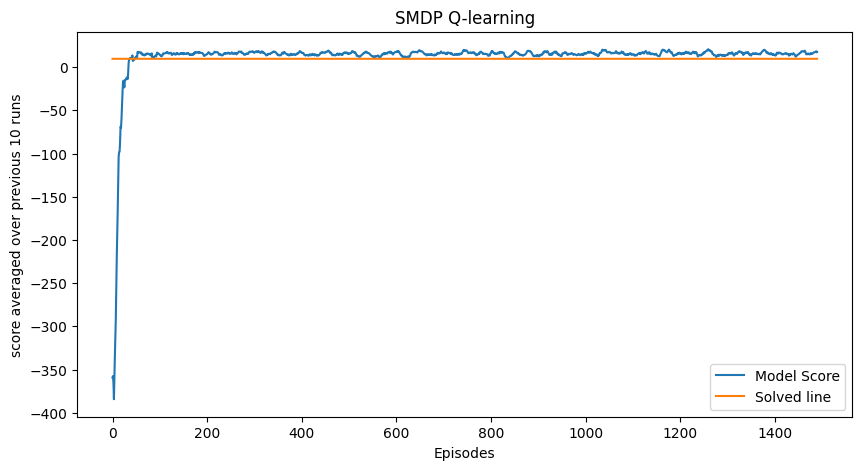

In [ ]:
Plot_rewards(rewards_smdp, 'SMDP Q-learning',10)

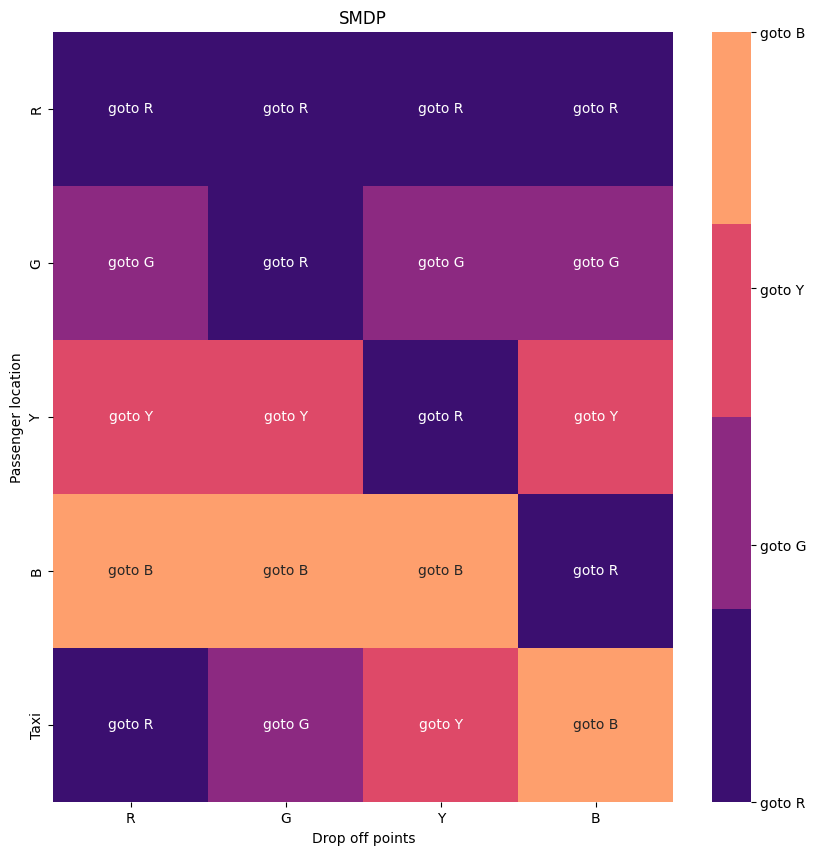

In [ ]:
Plot_Qvalues(q_values_SMDP, labels, destinations, passenger_locations, "SMDP")

## Experiment 2: Intra-Options Q-Learning

In [ ]:
# finetuned parameters:
#    best_io_alpha
#    best_io_eps_min
#    best_io_eps_decay

rewards_ioql, q_values_IOQL = intra_option_qlearning(
    env=env,
    goal=goal,
    q_value_shape=q_value_shape,
    alpha=alpha,
    gamma=gamma,
    eps_min=best_io_eps_min,
    eps_decay=best_io_eps_decay,
    runs=1500,
    show_progress=True
  )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Success (1/8) = 12.5%
Success (2/9) = 22.22222222222222%
Success (3/10) = 30.0%
Success (4/11) = 36.36363636363637%
Success (5/13) = 38.46153846153846%
Success (6/14) = 42.857142857142854%
Success (7/17) = 41.1764705882353%
Success (8/18) = 44.44444444444444%
Success (9/19) = 47.36842105263158%
Success (10/20) = 50.0%
Success (11/21) = 52.38095238095238%
Success (12/22) = 54.54545454545455%
Success (13/24) = 54.166666666666664%
Success (14/25) = 56.0%
Success (15/26) = 57.69230769230769%
Success (16/27) = 59.25925925925926%
Success (17/28) = 60.714285714285715%
Success (18/29) = 62.06896551724138%
Success (19/30) = 63.333333333333336%
Success (20/31) = 64.51612903225806%
Success (21/32) = 65.625%
Success (22/33) = 66.66666666666667%
Success (23/34) = 67.6470588235294%
Success (24/35) = 68.57142857142857%
Success (25/36) = 69.44444444444444%
Success (26/37) = 70.27027027027027%
Success (27/38) = 71.05263157894737%
Success (28/39) = 71.7948717948718%
Success (29/40) = 72.5%
Success (30/4

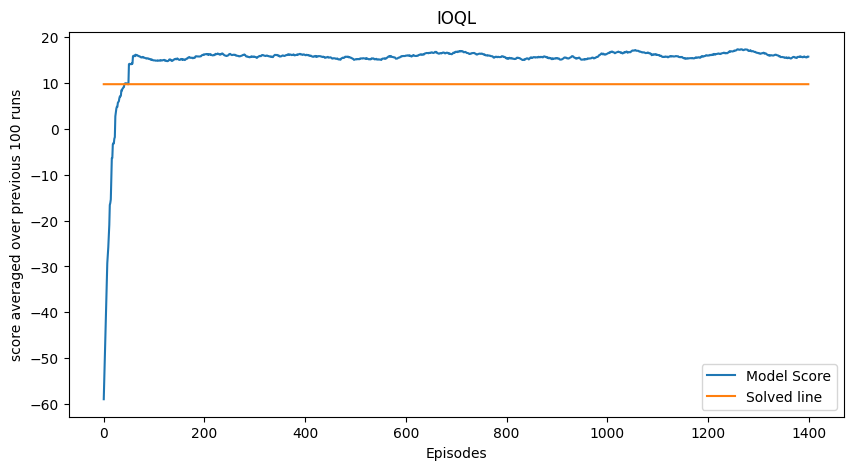

In [ ]:
Plot_rewards(rewards_ioql, 'IOQL')

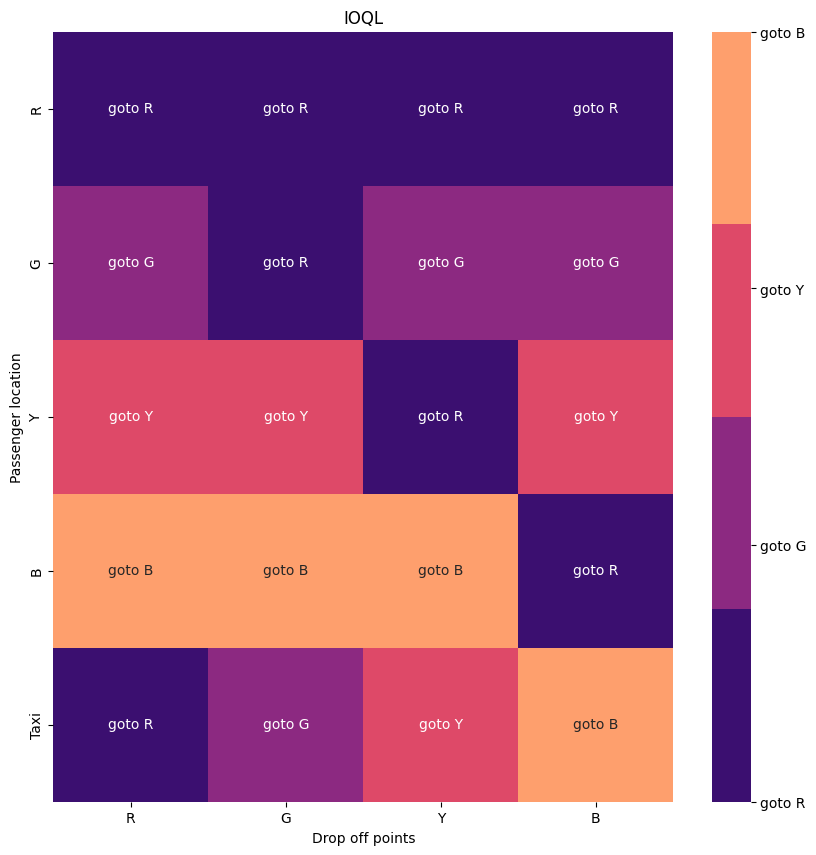

In [ ]:
Plot_Qvalues(q_values_IOQL, labels, destinations, passenger_locations, "IOQL")